In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import math
from scipy import stats

In [2]:
data_2021 = pd.read_csv("../data/airbnb_listings_2021.csv")
data_2021.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [3]:
# Dropping irrelevant columns and those that are unethical to use
data_2021.drop(["id", "host_name", "last_review", "license", "name", "host_id"], axis=1, inplace=True)

In [4]:
# Replacing the missing values for numerical columns with mean and mode
data_2021["number_of_reviews"] = data_2021["number_of_reviews"].fillna(
    data_2021["number_of_reviews"].mean()
)
data_2021["price"] = data_2021["price"].fillna(data_2021["price"].mean())
data_2021["minimum_nights"] = data_2021["minimum_nights"].fillna(
    data_2021["minimum_nights"].mean()
)
data_2021["reviews_per_month"] = data_2021["reviews_per_month"].fillna(
    data_2021["reviews_per_month"].mean()
)
data_2021["calculated_host_listings_count"] = data_2021[
    "calculated_host_listings_count"
].fillna(data_2021["calculated_host_listings_count"].mean())
data_2021["availability_365"] = data_2021["availability_365"].fillna(
    data_2021["availability_365"].mean()
)
data_2021["neighbourhood_group"] = data_2021["neighbourhood_group"].fillna(
    data_2021["neighbourhood_group"].mode()[0]
)
data_2021.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [5]:
#label encoding categorical columns
label_encoder = LabelEncoder()
data_2021['neighbourhood_group'] = label_encoder.fit_transform(data_2021['neighbourhood_group'])
data_2021['neighbourhood'] = label_encoder.fit_transform(data_2021['neighbourhood'])
data_2021['room_type'] = label_encoder.fit_transform(data_2021['room_type'])

In [6]:
#Remove outliers
z_scores = stats.zscore(data_2021)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_data = data_2021[filtered_entries]

In [7]:
#Scaling the data
scaler = StandardScaler()
#scaler.fit(new_data)
scaled_features = scaler.fit_transform(new_data)
scaled_features_data = pd.DataFrame(scaled_features, index=new_data.index, columns=new_data.columns)

In [8]:
#Creating train and test data
X = scaled_features_data.drop('price',axis=1)
y = scaled_features_data['price']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state=42)

In [9]:
#checking for multicollinearity 
#VIF starts at 1 and has no upper limit
#VIF = 1, no correlation between the independent variable and the other variables
#VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 
  
print(vif_data)

                           feature       VIF
0              neighbourhood_group  1.809058
1                    neighbourhood  1.133370
2                         latitude  1.866421
3                        longitude  1.118886
4                        room_type  1.079142
5                   minimum_nights  1.299873
6                number_of_reviews  1.242535
7                reviews_per_month  1.431738
8   calculated_host_listings_count  1.112164
9                 availability_365  1.125012
10           number_of_reviews_ltm  1.727239


In [10]:
#Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE',math.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score',r2_score(y_test, y_pred))
print('Adj R^2 value:',1 - (1-regressor.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

MSE 0.7686939933701766
RMSE 0.8767519565818924
R2 Score 0.2386353744429751
Adj R^2 value: 0.2371042938431347


In [11]:
#Regression output
X = sm.add_constant(X)
stats_model = sm.OLS(y,X)
results = stats_model.fit()
print ("r2/variance : ", results.rsquared)
print(results.summary())

r2/variance :  0.2507332849321956
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     833.4
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        21:08:56   Log-Likelihood:                -34932.
No. Observations:               27406   AIC:                         6.989e+04
Df Residuals:                   27394   BIC:                         6.999e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Text(0.5, 1.0, 'Model prediction')

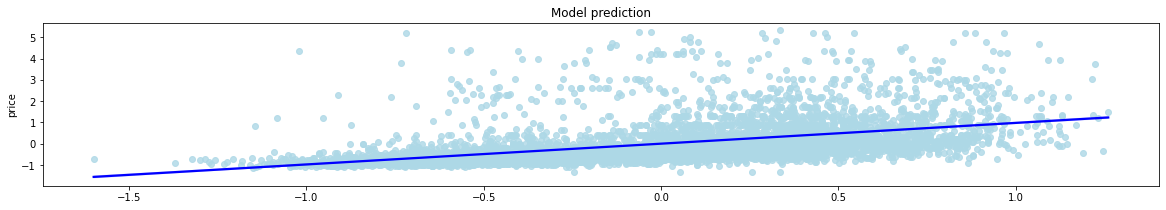

In [40]:
#model prediction
#price prediction
predictions = regressor.predict(X_test)
plt.figure(figsize=(20,3))
sns.regplot(y=y_test, x=predictions, scatter_kws={"color": "lightblue"}, line_kws={"color": "blue"})
plt.title('Model prediction')

In [39]:
#Actual vs. predicted values
error = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predictions.flatten()})
error.head(10)

,Actual Values,Predicted Values
0,1.094160,0.543019
1,-0.973390,-0.297634
2,-0.669338,-0.380366
3,-0.434784,-0.486117
4,0.425247,0.366998
5,0.868294,0.382654
6,-0.460846,0.188328
7,-0.530343,-0.891592
8,-0.478220,-0.401254
9,-0.269728,0.429613
